# Classify gravitational waves events with Machine Learning

Classify different gravitational waves events detected by LIGO using machine learning models from sklearn.

Project for the [*2019 Braga School Data science in (astro)particle physics and cosmology: the bridge to industry*](http://www.lip.pt/data-science-2019/?p=index)

Author: Pablo Villanueva Domingo

Date: March 2019

In [1]:
# General packages
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

# Sklearn classifiers
#!pip install sklearn
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# Load the data
metadata_filename = "data/gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv"
metadata_df = pd.read_csv(metadata_filename)

# Show all possible labels
print(metadata_df.label.unique())

# Show head of data
metadata_df.head(5)

['Scattered_Light' 'Repeating_Blips' 'Violin_Mode' 'Power_Line' 'Whistle'
 'Scratchy' 'Helix' 'Light_Modulation' 'Wandering_Line'
 'Low_Frequency_Burst' 'Koi_Fish' 'Low_Frequency_Lines' 'Blip'
 '1400Ripples' 'Chirp' 'Extremely_Loud' 'None_of_the_Above' 'Paired_Doves'
 'Tomte' 'Air_Compressor' 'No_Glitch' '1080Lines']


,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


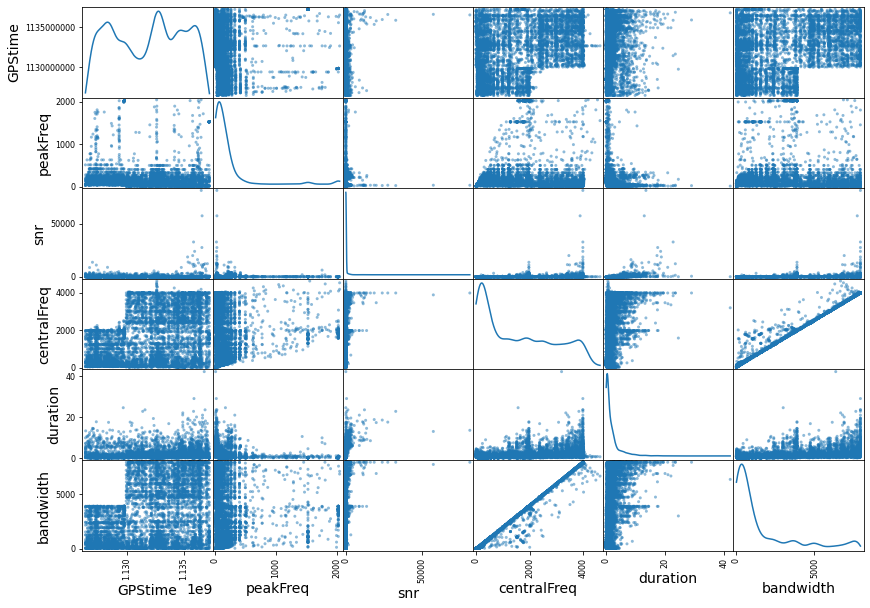

In [3]:
# Show a correlation scatter plot
scatter_matrix(metadata_df, diagonal="kde", figsize=(14,10))
plt.savefig("scatter_matrix.png", bbox_inches='tight')

In [4]:
# Select useful columns
X = metadata_df[["peakFreq","snr","centralFreq","duration", "bandwidth"]]
Y = metadata_df['label'].astype('category')

# Split training and test sets
validation_size = 0.20
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, stratify = Y)
X_train.head()

,peakFreq,snr,centralFreq,duration,bandwidth
6452,137.711,15.691,3019.445,0.227,5954.227051
2588,1527.022,10.686,1536.382,0.098,1074.647461
398,99.067,7.524,119.186,0.213,92.788773
2788,821.537,16.289,521.279,0.488,920.057373
2227,913.762,16.238,559.744,0.402,899.918457


In [5]:
# Training routine
def train_model(model, **params):

    clf = model(**params)
    clf.fit(X_train,Y_train)
    predictions = clf.predict(X_test)
    acc_train, acc_test = accuracy_score(Y_train, clf.predict(X_train)), accuracy_score(Y_test, predictions)
    print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
    #print(confusion_matrix(Y_test, predictions))
    #print(classification_report(Y_test, predictions))
    #return acc_test

In [6]:
# Try some models


#--- kNN ---#

vecinos_array = range(2,15,4)

for n_neighbors in vecinos_array:
    print("kNN", n_neighbors)
    train_model(KNeighborsClassifier, n_neighbors=n_neighbors)

#--- SVM ---#

gamma_array = [1e-6,1e-5]
c_array = [1e3,1e4]

for gamma in gamma_array:
    for c in c_array:
        print("SVM", gamma, c)
        train_model(SVC, gamma=gamma, C=c)

#--- Decision Tree ---#

print("Decision Tree")
train_model(DecisionTreeClassifier)


#--- Random Forest ---#

n_ests = [50, 100, 150]

for n_estimators in n_ests:
    print("Random Forest", n_estimators)
    train_model(RandomForestClassifier, n_estimators=n_estimators)

kNN 2
Train accuracy: 0.84, Test accuracy: 0.66
kNN 6
Train accuracy: 0.75, Test accuracy: 0.67
kNN 10
Train accuracy: 0.71, Test accuracy: 0.65
kNN 14
Train accuracy: 0.69, Test accuracy: 0.64
SVM 1e-06 1000.0
Train accuracy: 0.80, Test accuracy: 0.75
SVM 1e-06 10000.0
Train accuracy: 0.85, Test accuracy: 0.76
SVM 1e-05 1000.0
Train accuracy: 0.89, Test accuracy: 0.75
SVM 1e-05 10000.0
Train accuracy: 0.93, Test accuracy: 0.74
Decision Tree
Train accuracy: 1.00, Test accuracy: 0.81
Random Forest 50
Train accuracy: 1.00, Test accuracy: 0.86
Random Forest 100
Train accuracy: 1.00, Test accuracy: 0.86
Random Forest 150
Train accuracy: 1.00, Test accuracy: 0.86


In [7]:
# Use the best model to plot the results in 2D

labelx, labely = "centralFreq", "peakFreq"
#labelx, labely = "bandwidth", "peakFreq"
X = metadata_df[[labelx, labely]]

# Read categories and turn them into digits
Y = metadata_df['label'].astype('category')
Ydigits = pd.factorize(Y)[0]

# Make a grid in the parameter space
h = 10
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Choose the model
clf = RandomForestClassifier()
#clf = svm.SVC(gamma=1.e-5, C=1.e3)
#clf = KNeighborsClassifier(6)

# Fit, predict and reshape
clf.fit(X.values, Ydigits)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

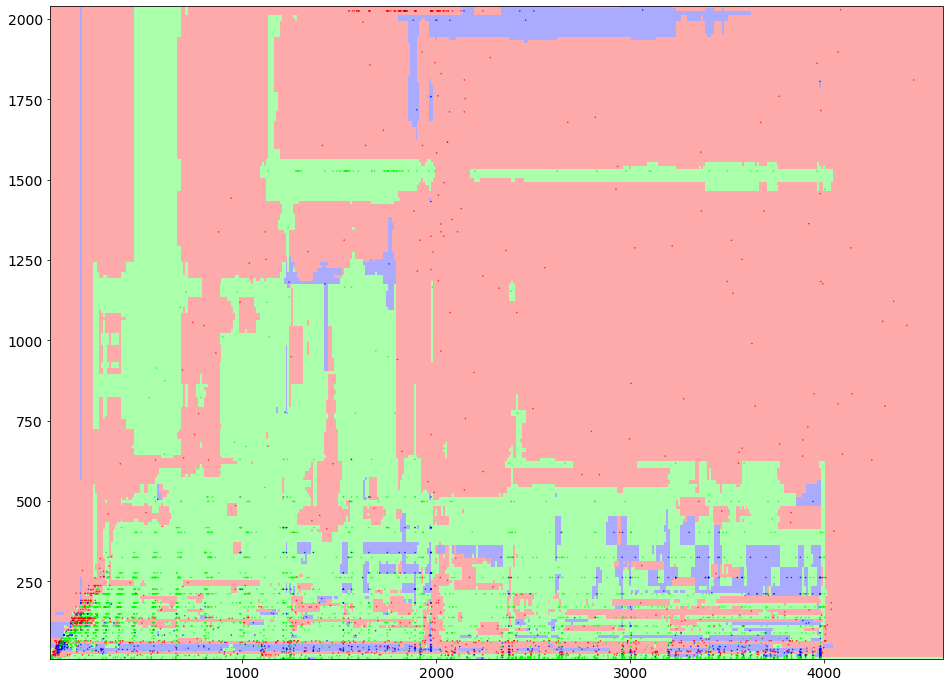

In [8]:
# Plot
plt.figure(figsize=(16,12))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Show predicted regions
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
# Show also training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Ydigits, cmap=cmap_bold, s=0.2)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(labelx)
plt.xlabel(labelx)
plt.savefig("regions.png")
plt.show()